In [1]:
from pathlib import PurePath
import os
import sys
os.chdir(PurePath(os.path.abspath('')).parent)
sys.path.append(os.getcwd())

In [2]:
import pandas as pd
import numpy as np
import re

from split_utils import read_fasta, Identity, compute_identity_stats
import matplotlib.pyplot as plt

In [3]:
MIN_SEQ_LEN = 5
MAX_SEQ_LEN = 50

# Filter dataset

In [4]:
fasta = read_fasta("../data/build/dataset.fasta")
dataset = [(id_, seq) for id_, seq in fasta if MIN_SEQ_LEN <= len(seq) <= MAX_SEQ_LEN]
output_path = ".cache/cdhit/dataset.fasta"
if not os.path.exists(PurePath(output_path).parent):
    os.makedirs(PurePath(output_path).parent)
with open(output_path, 'w') as f:
    for id_, seq in dataset:
        f.write(f">{id_}\n{seq}\n")
print(f"Filtered dataset saved to {output_path}")

Filtered dataset saved to .cache/cdhit/dataset.fasta


# Cluster sequences

In [5]:
!cd-hit -i ".cache/cdhit/dataset.fasta" -o ".cache/cdhit/clusters" -c 0.5 -n 2 -d 0 -M 30000 -T 10 -l 1

Program: CD-HIT, V4.8.1 (+OpenMP), Jun 25 2025, 18:10:39
Command: cd-hit -i .cache/cdhit/dataset.fasta -o
         .cache/cdhit/clusters -c 0.5 -n 2 -d 0 -M 30000 -T 10
         -l 1

Started: Thu Jun 26 10:14:35 2025
                            Output                              
----------------------------------------------------------------
total seq: 17935
longest and shortest : 50 and 5
Total letters: 308875
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 2M
Buffer          : 10 X 10M = 107M
Table           : 2 X 0M = 0M
Miscellaneous   : 0M
Total           : 110M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 3736196441

# comparing sequences from          0  to       1494
.---------- new table with      449 representatives
# comparing sequences from       1494  to       2864
100.0%---------- new table with      244 representatives
# comparing sequences from       2864 

# Load clusters

In [6]:
def parse_cdhit_clstr(clstr_path: str) -> pd.DataFrame:
    """
    Parses a CD-HIT .clstr file and returns a DataFrame with cluster and sequence IDs.

    Parameters:
    - clstr_path (str): Path to the .clstr file.

    Returns:
    - pd.DataFrame with columns: cluster_id, sequence_id
    """
    clusters = []
    current_cluster = -1

    with open(clstr_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>Cluster'):
                current_cluster += 1
            elif line:
                # Extract sequence ID from the line
                match = re.search(r'>?([\w|:.\-]+)\.\.\.', line)
                if match:
                    seq_id = int(match.group(1))
                    clusters.append((current_cluster, seq_id))
                else:
                    raise ValueError(f"Could not parse sequence ID from line: {line}")

    return pd.DataFrame(clusters, columns=["cluster_id", "sequence_id"])
clusters = parse_cdhit_clstr(".cache/cdhit/clusters.clstr")

# Split clusters into two sets

In [7]:
def split_clusters(clusters, test_ratio: float = 0.2):
    """
    Splits the clusters into training and test sets based on a given test ratio.
    :param clusters: The clusters DataFrame containing sequence IDs and their corresponding cluster IDs.
    :param test_ratio: The ratio of sequences to be included in the test set.
    :return: Two sets of ids, one for training and one for testing.
    """
    cluster_ids = clusters['cluster_id'].unique()
    print(f"Found {len(cluster_ids)} clusters in the dataset.")
    # Clusters are ordered by size, so we can just take the last n_test clusters in order to maximize the diversity
    # Compute the cumsum of the cluster sizes
    cluster_sizes = clusters['cluster_id'].value_counts().sort_index()
    cum_sum = cluster_sizes.cumsum()
    n_train = int(len(clusters) * (1 - test_ratio))
    train_mask = cum_sum <= n_train
    train_clusters = cluster_sizes[train_mask].index.tolist()
    test_clusters = cluster_sizes[~train_mask].index.tolist()
    train_ids = clusters[clusters['cluster_id'].isin(train_clusters)]['sequence_id'].tolist()
    test_ids = clusters[clusters['cluster_id'].isin(test_clusters)]['sequence_id'].tolist()
    return train_ids, test_ids

train_ids, test_ids = split_clusters(clusters)

Found 1444 clusters in the dataset.


# Assert independence between training and test sets

In [8]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")

 100%|██████████████████████████████████████|  3589/3589 [09:21<00:00, 6.27it/s] 


In [9]:
test2train_id = identities.max(axis=1)

Max identity: 0.9655172413793104
Mean identity: 0.6794233576529302
Median identity: 0.6923076923076923
Quantiles:
- 0.01 quantile: 0.3333333333333333
- 0.05 quantile: 0.38461538461538464
- 0.10 quantile: 0.4166666666666667
- 0.25 quantile: 0.4782608695652174
- 0.50 quantile: 0.6923076923076923
- 0.75 quantile: 0.875
- 0.90 quantile: 0.9285714285714286
- 0.95 quantile: 0.9473684210526315
- 0.99 quantile: 0.9583333333333334
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
7490


Text(0.5, 1.0, 'Highest identity between each test sequence and all train sequences')

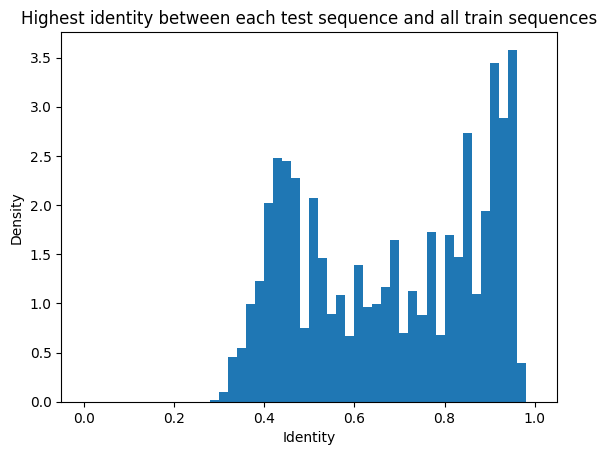

In [10]:
print(f"Max identity: {np.max(test2train_id)}")
print(f"Mean identity: {np.mean(test2train_id)}")
print(f"Median identity: {np.median(test2train_id)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(test2train_id, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(test2train_id, bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Highest identity between each test sequence and all train sequences")

Text(0.5, 1.0, 'Pairwise identity distribution between train and test')

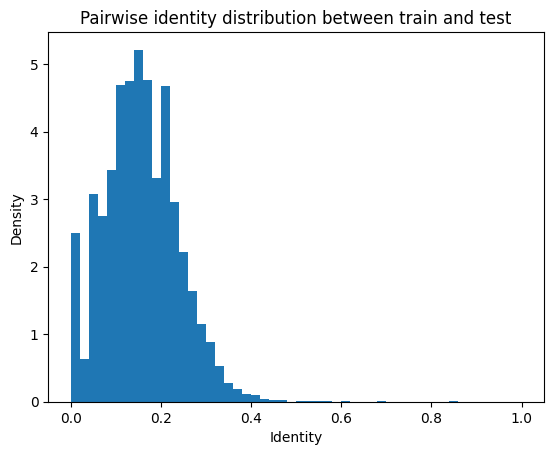

In [11]:
plt.hist(identities.reshape(-1), bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Pairwise identity distribution between train and test")

In [12]:
print(f"Length of train dataset: {len(train_ids)}")

Length of train dataset: 14346
